# Delay as LPF: smoothing average / averaging
Moving Average Filter Explained
The moving average filter works by averaging a set number of consecutive samples from the input signal. For a filter of length $N$, the output at time $n$ is calculated as:

$$y[n] = \frac{1}{N} \sum_{k=0}^{N-1} x[n-k]$$

Where:

* $y[n]$ is the output signal at time $n$,
* $x[n]$ is the input signal at time $n$,
* $N$ is the number of taps (coefficients) in the filter, also corresponding to the number of input samples considered for each output sample.

Each $x[n−k]$ in the equation represents a delayed version of the input signal by 
$k$ samples.

The length of the filter determines the cutoff frequency: the larger $N$ is, the lower the cutoff frequency. 

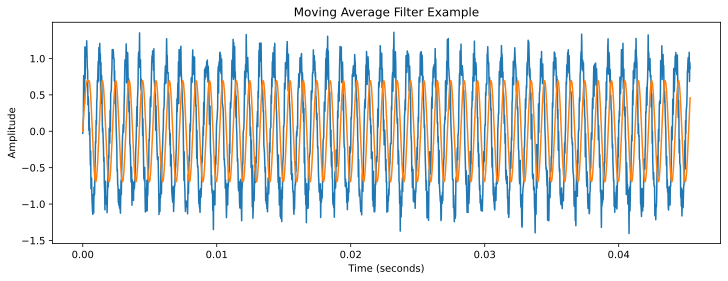

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average_filter(input_signal, N):
    # Create an array of zeros with the same length as the input signal
    output_signal = np.zeros_like(input_signal)
    # Apply the moving average filter
    for n in range(len(input_signal)):
        output_signal[n] = np.sum(input_signal[max(0, n-N+1):n+1]) / min(N, n+1)
    return output_signal

# Example usage
fs = 44100  # Sampling rate in Hz
t = np.linspace(0, 1, fs)  # 1 second of audio
f = 1000  # Frequency in Hz
N = 20  # Number of samples to average over

# Generate a sample input signal (e.g., a sine wave with added noise)
input_signal = np.sin(2 * np.pi * f * t)
noise = 0.15*np.random.randn(input_signal.size)
hif_sig = input_signal + noise

# Apply the moving average filter
output_signal = moving_average_filter(input_signal, N)

trunc_t = t[:2000]
trunc_in = hif_sig[:2000]
trunc_out = output_signal[:2000]

# Plot the input and filtered output signals
plt.plot(trunc_t, trunc_in, trunc_t, trunc_out, label='Input Signal')
plt.title('Moving Average Filter Example')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

In [2]:
## Relation to FFT

# Create low-pass filter through convolution

Designing an FIR filter typically involves determining the filter coefficients (impulse response) that define the filter's characteristics. One common method for designing FIR low-pass filters is using the window method, which involves creating an ideal filter response and then windowing it (to be finite).

A "perfect" filter shape would actually be rectangular. (In reality these are technically impossible to implement but high-order filters get close.) The rectangular shape, however, is the shape of the filter in the frequency domain. In order to get the shape of the associated time-domain object, we must take the inverse Fourier transform of the rectangular window. This gives us the impulse response. It turns out that this "perfect" impulse response that aligns with the rectangular window is an existing function: the sinc function.

The convolution of an input signal with a windowed sinc function (the filter's impulse response) applies the filter to the signal. Convolution in the time domain corresponds to multiplication in the frequency domain, so when you convolve your signal with the sinc-based impulse response, you're effectively applying the ideal low-pass filter's characteristics (as modified by windowing) to your signal.

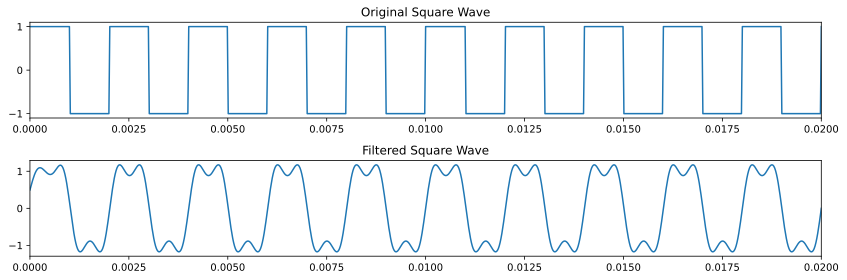

In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Generate a square wave signal
fs = 44100  
t = np.linspace(0, 1, fs)  # 1 second of audio
f = 500  # Frequency of the square wave in Hz
square_wave = signal.square(2 * np.pi * f * t)

# Design the low-pass filter
cutoff = 2000  # Cutoff frequency in Hz
num_taps = 100  # Number of filter coefficients (taps), i.e., length of IR
fir_coefficients = signal.firwin(num_taps, cutoff, fs=fs, window='hamming')

# Apply the filter
filtered_square_wave = np.convolve(square_wave, fir_coefficients, mode='same')

# Plot the original and filtered signals
# Original square wave
plt.subplot(2, 1, 1)
plt.plot(t, square_wave)
plt.title('Original Square Wave')
plt.xlim(0, 0.02)  # Zoom in to see the waveform clearly

# Filtered square wave
plt.subplot(2, 1, 2)
plt.plot(t, filtered_square_wave)
plt.title('Filtered Square Wave')
plt.xlim(0, 0.02)  # Zoom in to see the waveform clearly

plt.tight_layout()
plt.show()

# Basic IIR Low-Pass Filter
Similar to above, but more commonly used in DSP: A simple IIR low-pass filter can be described by the following difference equation:

$$y[n] = \alpha x[n] + (1 - \alpha) y[n-1]$$

Where:

* $y[n]$ is the output signal at time $n$,

* $x[n]$ is the input signal at time $n$,

* $y[n−1]$ is the previous output of the filter (hence, the delay element),

* $\alpha$ is a coefficient that determines the cutoff frequency of the filter. This coefficient typically ranges between 0 and 1, where values closer to 0 result in a lower cutoff frequency.

This formula represents a recursive filter where each output is a weighted average of the current input and the previous output.

Again, this formula effectively acts as a simple first-order, low-pass filter by mixing together current and past values, which mathematically dampens the amplitude of higher frequency components more than lower frequency components.

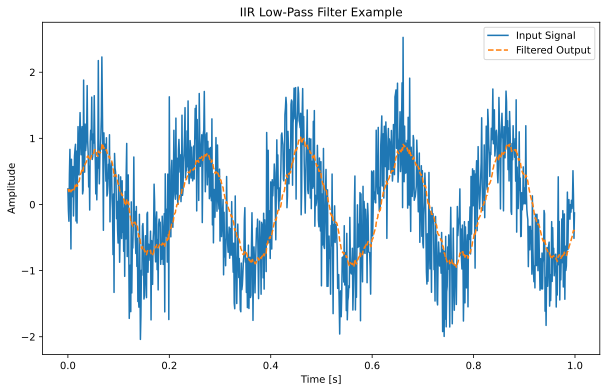

In [5]:
# Implement IIR Low-pass filter by using the formula above

def iir_low_pass_filter(input_signal, alpha):
    output_signal = [0] * len(input_signal) # Initialize output with same size as input
    
    # Set the first output sample equal to the first input sample 
    output_signal[0] = input_signal[0]
    
    # Apply the IIR low-pass filter to each sample
    for n in range(1, len(input_signal)):
        output_signal[n] = alpha * input_signal[n] + (1 - alpha) * output_signal[n-1]
    
    return output_signal


# Create a sample input signal: a sine wave with added noise
fs = 1000  
t = np.arange(0, 1, 1/fs)  
f = 5  # Frequency in Hz
input_signal = np.sin(2 * np.pi * f * t) + 0.5 * np.random.randn(len(t))  # Sine wave with noise

# Filter parameters
alpha = 0.05  # Filter coefficient -- play with this to see what happens!!! Can take value between 0 and 1

# Apply the IIR low-pass filter
output_signal = iir_low_pass_filter(input_signal, alpha)

# Plot the input and output signals
plt.figure(figsize=(10, 6))
plt.plot(t, input_signal, label='Input Signal')
plt.plot(t, output_signal, label='Filtered Output', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('IIR Low-Pass Filter Example')
plt.show()

# Using `scipy.signal.lfilter`

Fortunately, libraries exist with optimized code for filtering. A useful one is the `lfilter` function from scipy.signal. 



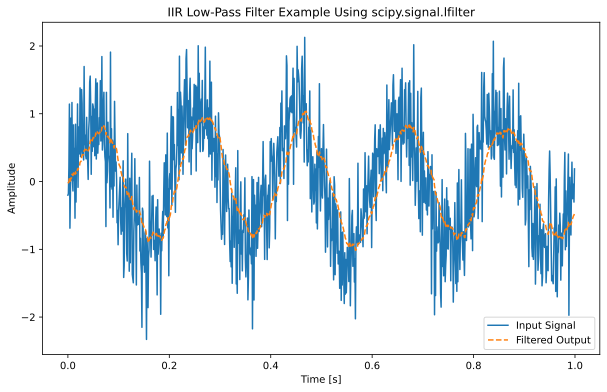

In [6]:
from scipy.signal import lfilter

# Define the filter coefficients
alpha = 0.05
b = [alpha]  # Numerator coefficients
a = [1, alpha - 1]  # Denominator coefficients

# Create a sample input signal: a sine wave with added noise
fs = 1000  # Sampling rate
t = np.arange(0, 1, 1/fs)  # Time vector
frequency = 5  # Frequency of the sine wave
input_signal = np.sin(2 * np.pi * frequency * t) + 0.5 * np.random.randn(len(t))  # Sine wave with noise

# Apply the IIR low-pass filter using lfilter
output_signal = lfilter(b, a, input_signal)

# Plot the input and output signals
plt.figure(figsize=(10, 6))
plt.plot(t, input_signal, label='Input Signal')
plt.plot(t, output_signal, label='Filtered Output', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('IIR Low-Pass Filter Example Using scipy.signal.lfilter')
plt.show()